In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

sns.set_style('ticks')

from tqdm import tqdm
from itertools import count

In [2]:
def k_bandit(k=10, n_timesteps=1000, epsilon=0.0, q1=0, alpha=None, ucb_c=0, random_walk=0):
    """
    Performs simple learning on a k-armed bandit task. 
    
    First the testbed is setup by drawing `k` expected rewards (true value q) from N(0, 1). The experiment will be run for
    a total of `n_timesteps`. Reward for an action R(action) ~ N(q(action), 1)
    
    Initial estimated reward value of `q1` is assigned to all actions. Set this value to a high number (e.g. q1=5)
    to experiment with optimistic greedy.
    
    `epsilon` controls the probability with which an action is selected "non-greedily" -- rather an action
    is selected from all k choices with equal chance.
    
    The estimated value of the selection action is updated according to the following:
    
    Q_a(t+1) = Q_a(t) + alpha(a, n, t) * (R(a) - Q(t))
    
    where 
        a: action
        n: number of times the action has been encountered (including this round)
        t: current timestep
        Q_a: estimated reward for action a
        R(a): reward for taking the action a
    
    `alpha` can either be a fixed value or a function that takes in three position arguments a, n, and t, returning
    a scalar. By default, `alpha=None`, in which case, sample-average method is used where:
    
    alpha(a, n, t) = 1 / n
    
    Selecting value of ucb_c > 0 will turn on use of Upper-Confidence Bound implementation for evaluating the
    current estimated value:
    
    Q_ucb(action) = Q(action) + ucb_c * sqrt(ln(t) / n(action))
    
    Note that you can combine `epsilon` > 0 with `ucb_c` > 0 in this implementation.
    
    Finally, `random_walk` controlls the level of random walk applied to the value. If `random_walk` > 0, then after
    the every time step, for each action, the true value of the action is updated as follows:
    
    q(t+1) ~ N(q(t), random_walk^2)
    
    and thus the value of `random_walk` specifies the standard deviation of the random walk process.
    
    By setting `random_walk` > 0, you can experiment with the case of non-stationary values.
    
    
    The function returns three arrays of size (n_timesteps,):
        optimal_action: an array of optimal action at each time step. Unless `random_walk` > 0, this should be
            filled with a single value
        action_history: an array of chosen action at each time step
        reward_history: an array of obtained reward at each time step
    """
    q = np.ones(k) * q1
    n = np.zeros(k)
    values = np.random.randn(k)
        

    if alpha is None:
        alpha = lambda a, n, t: 1/n
        
    if not callable(alpha):
        # the following needed to avoid problems due to closure
        fixed_alpha = alpha
        alpha = lambda x: fixed_alpha

    optimal_action = []
    action_history = []
    reward_history = []

    for t in range(n_timesteps):
        # find out what would have been the optimal action
        optimal_action.append(np.argmax(values))
        
        if np.random.rand() < epsilon:
            action = np.random.randint(k)
        else:
            # for imlementational clarity treat ucb_c > 0 case explicitly
            if ucb_c > 0:
                if np.any(n == 0):
                    choices = np.where(n == 0)[0]
                else:
                    q_ucb = q + ucb_c * np.sqrt(np.log(k)/ n)
                    q_ucb_max = np.max(q_ucb)
                    # if there are ties, randomly break the tie
                    choices = np.where(q_ucb == q_ucb_max)[0]
            else:
                q_max = np.max(q)
                choices = np.where(q == q_max)[0]
            action = choices[np.random.randint(len(choices))]

        action_history.append(action)
        reward = np.random.randn() + values[action]
        reward_history.append(reward)

        n[action] += 1
        q[action] = q[action] + alpha(action, n[action], t) * (reward - q[action])
        
        # walk the values
        if random_walk > 0:
            values += np.random.randn(k) * random_walk
    
    optimal_action = np.array(optimal_action)
    action_history = np.array(action_history)
    reward_history = np.array(reward_history)
    return optimal_action, action_history, reward_history

## Run experiments

In [11]:
n_experiments = 1000
# params = [dict(epsilon=0, q1=5), dict(epsilon=0, q1=0), dict(epsilon=0, q1=0, ucb_c=2)]
params = [dict(epsilon=0, q1=5), dict(epsilon=0, q1=0), dict(epsilon=0.1, q1=0)]

results = []

# use a constant step alpha
alpha = lambda a, n, t: 0.1

for i, param in enumerate(params):
    print('Performing experiments with', param)
    average_reward = 0
    average_best_action = 0
    for _ in tqdm(range(n_experiments)):    
        optimal_action, action_history, reward_history = k_bandit(**param, alpha=alpha)
        average_best_action += (action_history == optimal_action) / n_experiments
        average_reward += reward_history / n_experiments
    result = dict(average_reward=average_reward, average_best_action=average_best_action, optimal_action=optimal_action)
    results.append(result)

Performing experiments with {'epsilon': 0, 'q1': 5}


100%|██████████| 1000/1000 [00:38<00:00, 25.85it/s]


Performing experiments with {'epsilon': 0, 'q1': 0}


100%|██████████| 1000/1000 [00:38<00:00, 25.81it/s]


Performing experiments with {'epsilon': 0.1, 'q1': 0}


100%|██████████| 1000/1000 [00:34<00:00, 28.96it/s]


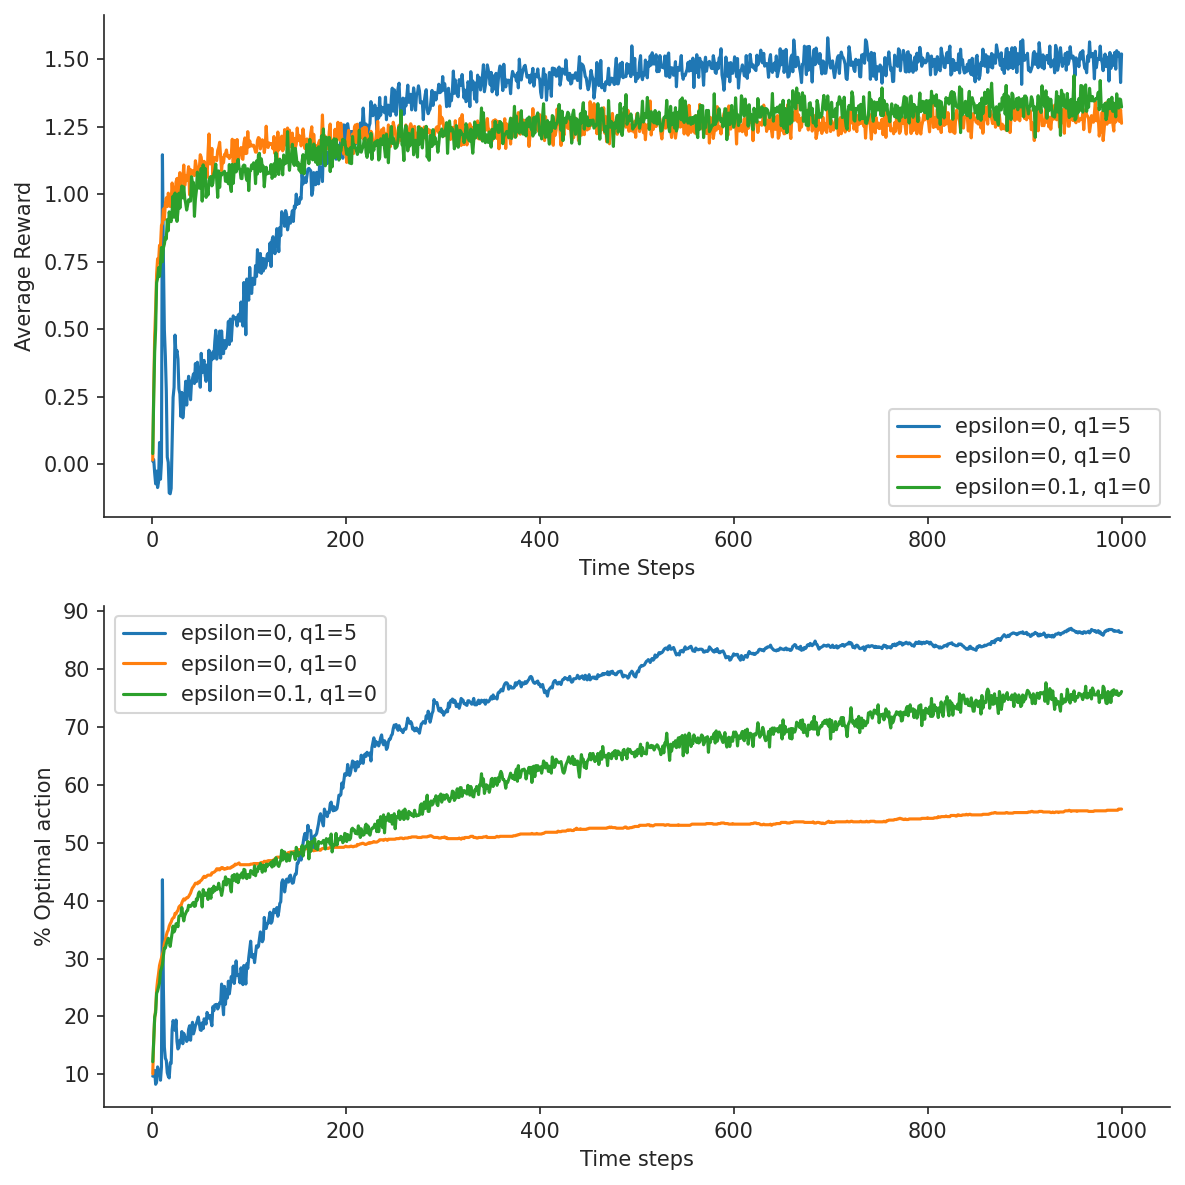

In [17]:
labels = [', '.join('{}={}'.format(k, v) for k, v in entry.items()) for entry in params]

fig, axs = plt.subplots(2, 1, dpi=150, figsize=(8, 8))


ax = axs[0]

for label, data in zip(labels, results):
    n_timesteps = len(data['average_reward'])
    timesteps = np.arange(n_timesteps) + 1
    ax.plot(timesteps, data['average_reward'], label=label)
    
# ax.set_xlabel('Time steps')
# ax.set_ylabel('Average Reward')
ax.set(xlabel='Time Steps', ylabel='Average Reward')
sns.despine()
ax.legend()

ax = axs[1]

for label, data in zip(labels, results):
    n_timesteps = len(data['average_best_action'])
    timesteps = np.arange(n_timesteps) + 1
    ax.plot(timesteps, 100 * data['average_best_action'], label=label)
ax.set_xlabel('Time steps')
ax.set_ylabel('% Optimal action')
# ax.set_xlim([0, 50])
ax.legend()
sns.despine()


fig.tight_layout()
